[Kaggle - Ecommerce](https://www.kaggle.com/carrie1/ecommerce-data)

## Table of contents
1. [Check missing values](#missingvalues)
2. [EDA](#EDA)
    1. [Conclusion](#conclusion)
3. [Purchase Pattern Analysis](#purchasepattern)
    1. [year, month, day, dayofweek, hour](#3.1)
    2. [Reorder / First order](#3.2)
    3. [New Customers](#3.3)
4. [RFM Analysis](#RFM)
    1. [Recency](#4.1)
    2. [Frequency](#4.2)
    3. [Monetary](#4.3)
    4. [Combine into RFM table](#4.4)
    5. [Customer segments with RFM Model](#4.5)
        1. [Kmeans](#4.5.1)
        2. [RFM Scores](#4.5.2)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./input/data.csv", encoding="ISO-8859-1", parse_dates=['InvoiceDate'])

print("df.shape:", df.shape)
display(df.head())
display(df.info())

df.shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


None

**observations:**
* InvoiceNo: str means there are alphabet in str
* nulls in Description, CustomerID

---
# 1) Check missing values<a class="anchor" id="missingvalues"></a>

### check why CustomerID is null

In [3]:
print(df[df.CustomerID.isnull()].shape)
df[df.CustomerID.isnull()].head()

(135080, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [4]:
df[df.CustomerID.isnull()].describe()

,Quantity,UnitPrice,CustomerID
count,135080.000000,135080.000000,0.0
mean,1.995573,8.076577,NaN
std,66.696153,151.900816,NaN
min,-9600.000000,-11062.060000,NaN
25%,1.000000,1.630000,NaN
50%,1.000000,3.290000,NaN
75%,3.000000,5.450000,NaN
max,5568.000000,17836.460000,NaN


**observations:**
* Outliers in Quantity & UnitPrice

### check why Description is null

In [5]:
print(df[df.Description.isnull()].shape)
df[df.Description.isnull()].head()

(1454, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


In [6]:
df[df.Description.isnull()].describe()

,Quantity,UnitPrice,CustomerID
count,1454.000000,1454.0,0.0
mean,-9.359697,0.0,NaN
std,243.238758,0.0,NaN
min,-3667.000000,0.0,NaN
25%,-24.000000,0.0,NaN
50%,-3.000000,0.0,NaN
75%,4.000000,0.0,NaN
max,5568.000000,0.0,NaN


**observations:**
* When Description=na, CustomerID=na & UnitPrice=0
    * Therefore, delete Description=na

---
# 2) EDA<a class="anchor" id="EDA"></a>

### InvoiceNo

In [7]:
df.InvoiceNo.value_counts()

573585    1114
581219     749
581492     731
580729     721
558475     705
          ... 
537870       1
577848       1
558268       1
536550       1
538719       1
Name: InvoiceNo, Length: 25900, dtype: int64

* The largest single invoice is 573585, which bought 1114 items

In [8]:
print(df[df.InvoiceNo.str.contains('C')].shape)
df[df.InvoiceNo.str.contains('C')].head()

(9288, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


* InvoiceNo start with 'C' means canceled invoice (Quantity < 0)

### StockCode

In [9]:
df.StockCode.value_counts()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
85160a       1
72789        1
90092        1
84251F       1
21923        1
Name: StockCode, Length: 4070, dtype: int64

In [10]:
df[df.StockCode=='85123A']['Description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    2302
CREAM HANGING HEART T-LIGHT HOLDER       9
wrongly marked carton 22804              1
?                                        1
Name: Description, dtype: int64

* Most bought item is 85123A which is a type of HOLDER

### Description

In [11]:
df.Description.value_counts(dropna=False)

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
                                      ... 
reverse previous adjustment              1
?sold as sets?                           1
IVORY PANTRY HANGING LAMP                1
CHRISTMAS CRAFT HEART STOCKING           1
MINT DINER CLOCK                         1
Name: Description, Length: 4224, dtype: int64

* Most bought item is WHITE HANGING HEART T-LIGHT HOLDER

### Quantity

In [12]:
df.Quantity.value_counts()

 1       148227
 2        81829
 12       61063
 6        40868
 4        38484
          ...  
 1287         1
-5368         1
 267          1
-244          1
 512          1
Name: Quantity, Length: 722, dtype: int64

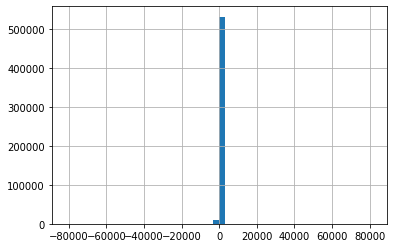

In [13]:
df.Quantity.hist(bins=50)

* most customers bought few items per each purchase
* -ve Quantity means?

In [14]:
df[df.Quantity < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


* -ve Quantity means Discount

### InvoiceDate

In [15]:
earliest_date = df.InvoiceDate.min()
latest_date = df.InvoiceDate.max()
time_period = latest_date - earliest_date

print('earliest_date:', earliest_date)
print('latest_date:', latest_date)
print('time_period:', time_period)

earliest_date: 2010-12-01 08:26:00
latest_date: 2011-12-09 12:50:00
time_period: 373 days 04:24:00


* The data recorded for 1 year +

### UnitPrice

In [16]:
df.UnitPrice.value_counts()

1.25       50496
1.65       38181
0.85       28497
2.95       27768
0.42       24533
           ...  
4575.64        1
125.96         1
147.13         1
3060.60        1
244.51         1
Name: UnitPrice, Length: 1630, dtype: int64

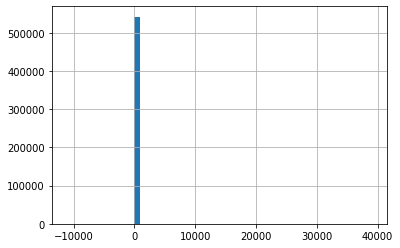

In [17]:
df.UnitPrice.hist(bins=50)

* cheap items are most popular

In [18]:
df[df.UnitPrice < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


* -ve UnitPrice means adjusting bad debt

### CustomerID

In [19]:
df.CustomerID.value_counts(dropna=False)

NaN        135080
17841.0      7983
14911.0      5903
14096.0      5128
12748.0      4642
            ...  
16148.0         1
16144.0         1
16138.0         1
16093.0         1
17948.0         1
Name: CustomerID, Length: 4373, dtype: int64

* Customer 17841 bought the most number of items in the past record
* because we want to look at the customer segmentation, so we delete CustomerID = na

### Country

In [20]:
df.Country.value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

* UK bought most items

## Conclusion<a class="anchor" id="conclusion"></a>
* Look into UK only because there are the most data
* Select the 365 days data starting from 2010-12-01 to 2011-11-30 (to have 整月)
* Select Quantity > 0 (neglect discount) & UnitPrice >= 0 (neglect bad debt)
* delete CustomerID = na
* delete Description = na

In [21]:
df_uk = df[df.Country == 'United Kingdom']

df_uk = df_uk[df_uk.InvoiceDate < '2011-12-01']

df_uk = df_uk[(df_uk.Quantity > 0) & (df_uk.UnitPrice >= 0)]

df_uk = df_uk.dropna(subset=['CustomerID', 'Description'], axis=0, how='any')

df_uk.InvoiceNo = df_uk.InvoiceNo.astype(int)
df_uk.CustomerID = df_uk.CustomerID.astype(int)

df_uk = df_uk.drop('Country', axis=1)

df_uk['TotalPrice'] = df_uk.Quantity * df_uk.UnitPrice

df_uk

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,20.34
...,...,...,...,...,...,...,...,...
516364,579885,85034C,3 ROSE MORRIS BOXED CANDLES,4,2011-11-30 17:37:00,1.25,15444,5.00
516365,579885,21742,LARGE ROUND WICKER PLATTER,2,2011-11-30 17:37:00,5.95,15444,11.90
516366,579885,23084,RABBIT NIGHT LIGHT,6,2011-11-30 17:37:00,2.08,15444,12.48
516367,579885,21257,VICTORIAN SEWING BOX MEDIUM,1,2011-11-30 17:37:00,7.95,15444,7.95


In [22]:
df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338544 entries, 0 to 516368
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    338544 non-null  int32         
 1   StockCode    338544 non-null  object        
 2   Description  338544 non-null  object        
 3   Quantity     338544 non-null  int64         
 4   InvoiceDate  338544 non-null  datetime64[ns]
 5   UnitPrice    338544 non-null  float64       
 6   CustomerID   338544 non-null  int32         
 7   TotalPrice   338544 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1), object(2)
memory usage: 20.7+ MB


---
# 3) Purchase Pattern Analysis<a class="anchor" id="purchasepattern"></a>

## 3.1) year, month, day, dayofweek, hour<a class="anchor" id="3.1"></a>

In [23]:
df_uk_pattern = df_uk.copy()

# Set InvoiceDate as time index
df_uk_pattern = df_uk_pattern.set_index('InvoiceDate')

df_uk_pattern['year'] = df_uk_pattern.index.year
df_uk_pattern['month'] = df_uk_pattern.index.month
df_uk_pattern['year-month'] = df_uk_pattern.index.to_period('M')
df_uk_pattern['week'] = df_uk_pattern.index.week
df_uk_pattern['day'] = df_uk_pattern.index.day
df_uk_pattern['weekday'] = df_uk_pattern.index.weekday
df_uk_pattern['hour'] = df_uk_pattern.index.hour

df_uk_pattern.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,TotalPrice,year,month,year-month,week,day,weekday,hour
InvoiceDate,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,15.30,2010,12,2010-12,48,1,2,8
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,20.34,2010,12,2010-12,48,1,2,8
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,22.00,2010,12,2010-12,48,1,2,8
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,20.34,2010,12,2010-12,48,1,2,8
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,20.34,2010,12,2010-12,48,1,2,8


### 1) Sales by month

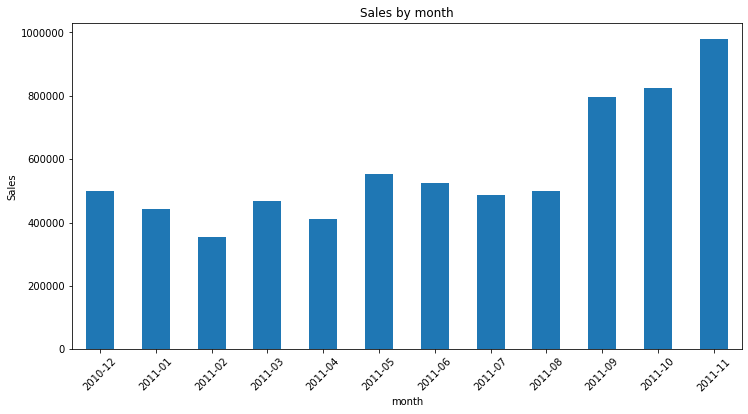

In [24]:
bymonth = df_uk_pattern.groupby(['year-month'])['TotalPrice'].sum()

plt.figure(figsize=(12, 6))
bymonth.plot.bar()
plt.title("Sales by month")
plt.xlabel('month')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

**Observations:**
* increasing trend in TotalPrice

### 2) Sales by week

In [25]:
byweek2010 = df_uk_pattern['2010'].groupby('week')['TotalPrice'].sum()
byweek2011 = df_uk_pattern['2011'].groupby('week')['TotalPrice'].sum()

byweek = pd.concat([byweek2010, byweek2011], axis=0)
byweek[:10]

week
48    134058.00
49    187062.94
50    147026.08
51     30514.83
1      97321.08
2     109421.12
3     142150.28
4      80538.16
5      89957.44
6      73519.98
Name: TotalPrice, dtype: float64

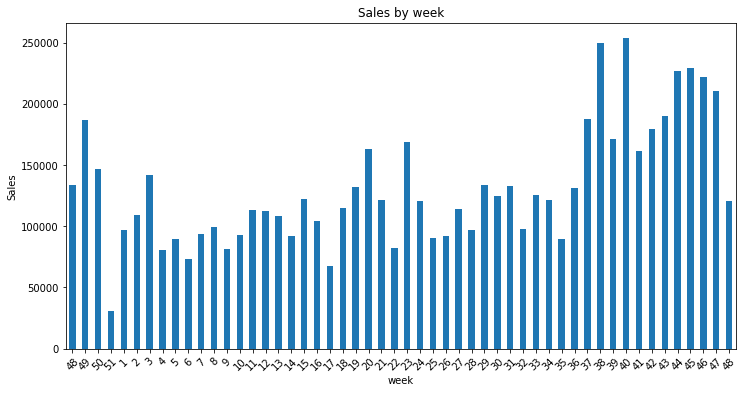

In [26]:
plt.figure(figsize=(12, 6))
byweek.plot.bar()
plt.title("Sales by week")
plt.xlabel('week')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

**Observations:**
* Smaller transcation in the beginning of year and higher transcation in the end of year
* week 38 & 40 reached the peak (holiday, promotion sale?)

### 3) Sales by weekday

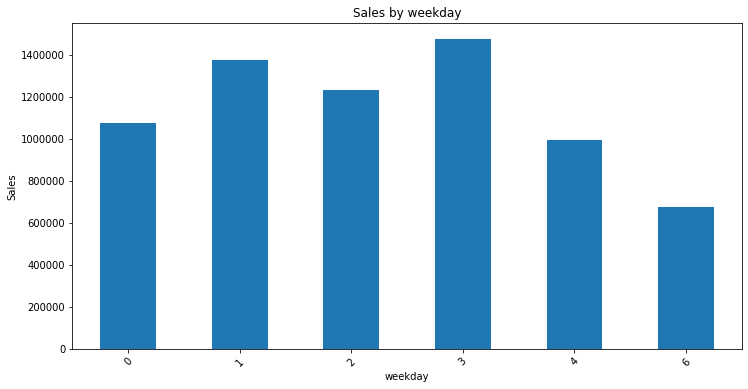

In [27]:
byweekday = df_uk_pattern.groupby(['weekday'])['TotalPrice'].sum()

plt.figure(figsize=(12, 6))
byweekday.plot.bar()
plt.title("Sales by weekday")
plt.xlabel('weekday')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

**Observations:**
* Tue & Thur have the most active transaction
* Inactive in Sun

### 4) Sales by hour

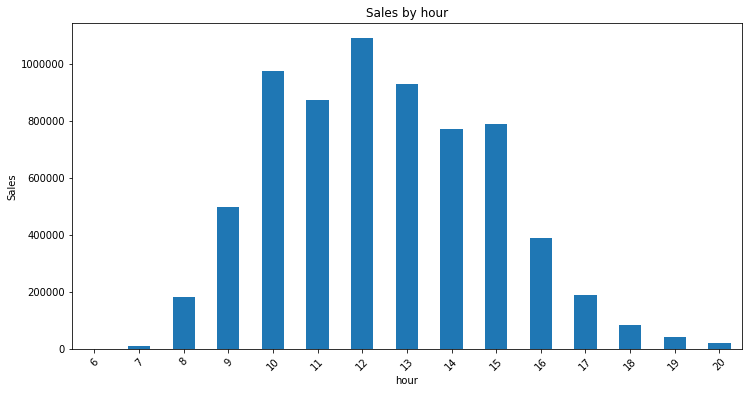

In [28]:
byhour = df_uk_pattern.groupby(['hour'])['TotalPrice'].sum()

plt.figure(figsize=(12, 6))
byhour.plot.bar()
plt.title("Sales by hour")
plt.xlabel('hour')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

**Observations:**
* 10am to 15pm: active transaction (start rising at 9am, declining at 4pm)

### 5) Sales of weekday vs hour

In [29]:
df_weekdayvshour = df_uk_pattern.groupby(["weekday", "hour"]).agg({'TotalPrice': np.sum})
df_weekdayvshour

TotalPrice
weekday hour            
0       7        955.580
        8      33353.420
        9      94492.520
        10    119852.280
        11    119451.780
...                  ...
6       12    142930.660
        13    122172.770
        14     91199.871
        15    100559.510
        16     30007.180

[73 rows x 1 columns]

In [30]:
pivot_weekdayvshour = pd.pivot(data= df_weekdayvshour.reset_index(),
                               index='weekday',
                               columns='hour',
                               values='TotalPrice')

pivot_weekdayvshour

hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
weekday,,,,,,,,,,,,,,,
0,NaN,955.58,33353.42,94492.520,119852.280,119451.78,156998.06,172368.34,154942.360,127548.21,66664.13,27831.091,NaN,NaN,NaN
1,NaN,1818.58,53496.08,112344.970,262789.721,210093.57,208335.29,173390.26,126561.860,122933.64,79042.87,25398.340,299.02,NaN,NaN
2,NaN,3343.46,30442.08,84669.680,196167.360,166953.72,204030.03,175158.09,138973.690,128760.82,68818.86,18187.210,NaN,3053.40,13031.50
3,4.25,2904.72,31509.84,106745.490,181229.780,131564.32,204895.56,152979.01,151567.290,189184.58,106946.56,91777.640,83846.26,37203.22,5817.57
4,NaN,2102.24,32463.23,98422.381,139188.470,130088.20,172756.44,133391.38,108107.220,120176.81,37154.48,23539.300,33.00,373.46,22.14
6,NaN,NaN,NaN,778.800,74615.590,115196.29,142930.66,122172.77,91199.871,100559.51,30007.18,NaN,NaN,NaN,NaN


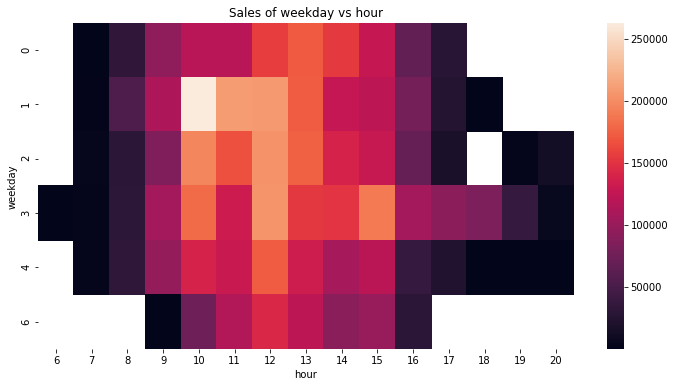

In [31]:
plt.figure(figsize=(12,6))
sns.heatmap(pivot_weekdayvshour)
plt.title("Sales of weekday vs hour")
plt.show()

**Observations:**
* 10am on Tuesday reached peak transaction in TotalPrice
* Tue, Wed, Thur have more transaction
* On Thur, active transcation last longer til 6pm
* On Sun, opening hour starts from 9am to 4pm

## 3.2) Reorder / First order<a class="anchor" id="3.2"></a>

In [32]:
# Use df_uk & sort by ['CustomerID', 'StockCode', 'InvoiceDate']
df_uk_reorder = df_uk.copy().sort_values(['CustomerID', 'StockCode', 'InvoiceDate'])

df_uk_reorder

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,77183.60
106282,545321,20711,JUMBO BAG TOYS,20,2011-03-01 14:53:00,1.95,12747,39.00
9760,537215,21136,PAINTED METAL PEARS ASSORTED,8,2010-12-05 15:38:00,1.69,12747,13.52
64849,541677,21136,PAINTED METAL PEARS ASSORTED,16,2011-01-20 14:01:00,1.69,12747,27.04
106291,545321,21136,PAINTED METAL PEARS ASSORTED,16,2011-03-01 14:53:00,1.69,12747,27.04
...,...,...,...,...,...,...,...,...
198742,554065,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,12,2011-05-22 10:39:00,1.65,18287,19.80
392744,570715,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,48,2011-10-12 10:23:00,1.45,18287,69.60
198740,554065,85040A,S/4 PINK FLOWER CANDLES IN BOWL,36,2011-05-22 10:39:00,1.65,18287,59.40
198743,554065,85040A,S/4 PINK FLOWER CANDLES IN BOWL,12,2011-05-22 10:39:00,1.65,18287,19.80


In [33]:
# shift by 1 to see if it is reorder
df_uk_reorder_shift1 = df_uk_reorder.shift(1)
df_uk_reorder['reorder'] = np.where(df_uk_reorder['StockCode'] == df_uk_reorder_shift1['StockCode'], 1,0)

# Create year-month
df_uk_reorder['year-month'] = df_uk_reorder.InvoiceDate.dt.to_period('M')

df_uk_reorder.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice,reorder,year-month
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,77183.60,0,2011-01
106282,545321,20711,JUMBO BAG TOYS,20,2011-03-01 14:53:00,1.95,12747,39.00,0,2011-03
9760,537215,21136,PAINTED METAL PEARS ASSORTED,8,2010-12-05 15:38:00,1.69,12747,13.52,0,2010-12
64849,541677,21136,PAINTED METAL PEARS ASSORTED,16,2011-01-20 14:01:00,1.69,12747,27.04,1,2011-01
106291,545321,21136,PAINTED METAL PEARS ASSORTED,16,2011-03-01 14:53:00,1.69,12747,27.04,1,2011-03


### 1) Top 10 Reorder Item

In [34]:
df_uk_reorder.groupby(['Description']).agg({'reorder': np.sum}).sort_values('reorder', ascending=False).head(10)

,reorder
Description,
WHITE HANGING HEART T-LIGHT HOLDER,1077
JUMBO BAG RED RETROSPOT,873
LUNCH BAG RED RETROSPOT,667
ASSORTED COLOUR BIRD ORNAMENT,661
PARTY BUNTING,637
REGENCY CAKESTAND 3 TIER,628
LUNCH BAG BLACK SKULL.,589
LUNCH BAG SUKI DESIGN,563
JUMBO BAG PINK POLKADOT,478


### 2) Sales by Month

In [35]:
bymonth_reorder = df_uk_reorder.groupby(['year-month', 'reorder']).agg({'TotalPrice': np.sum}).reset_index()

bymonth_reorder.head()

,year-month,reorder,TotalPrice
0,2010-12,0,413284.05
1,2010-12,1,85377.80
2,2011-01,0,367573.41
3,2011-01,1,74616.65
4,2011-02,0,245893.04


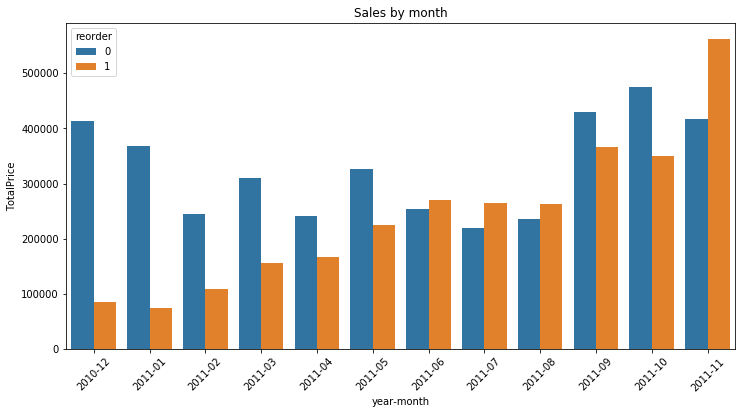

In [36]:
plt.figure(figsize=(12, 6))
sns.barplot(data=bymonth_reorder,
            x='year-month',
            y='TotalPrice',
            hue='reorder')

plt.title("Sales by month")
plt.xticks(rotation=45)
plt.show()

**Observations:**
* reorder is increasing

## 3.3) New customer<a class="anchor" id="3.3"></a>

In [37]:
# Use df_uk & sort by ['CustomerID', 'InvoiceDate']
df_uk_newcus = df_uk.copy().sort_values(['CustomerID', 'InvoiceDate'])

df_uk_newcus

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,77183.60
9754,537215,85124C,GREEN JUICY FRUIT PHOTO FRAME,12,2010-12-05 15:38:00,2.55,12747,30.60
9755,537215,85124B,BLUE JUICY FRUIT PHOTO FRAME,6,2010-12-05 15:38:00,2.55,12747,15.30
9756,537215,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2010-12-05 15:38:00,1.69,12747,27.04
9757,537215,85062,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,24,2010-12-05 15:38:00,1.65,12747,39.60
...,...,...,...,...,...,...,...,...
392752,570715,22419,LIPSTICK PEN RED,12,2011-10-12 10:23:00,0.42,18287,5.04
392753,570715,22866,HAND WARMER SCOTTY DOG DESIGN,12,2011-10-12 10:23:00,2.10,18287,25.20
423939,573167,23264,SET OF 3 WOODEN SLEIGH DECORATIONS,36,2011-10-28 09:29:00,1.25,18287,45.00
423940,573167,21824,PAINTED METAL STAR WITH HOLLY BELLS,48,2011-10-28 09:29:00,0.39,18287,18.72


In [38]:
# drop_duplicates ['CustomerID', 'InvoiceDate']
df_uk_newcus = df_uk_newcus.drop_duplicates(subset=['CustomerID', 'InvoiceDate'], keep='first')

df_uk_newcus

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,77183.60
9754,537215,85124C,GREEN JUICY FRUIT PHOTO FRAME,12,2010-12-05 15:38:00,2.55,12747,30.60
27390,538537,22795,SWEETHEART RECIPE BOOK STAND,16,2010-12-13 10:41:00,5.95,12747,95.20
64849,541677,21136,PAINTED METAL PEARS ASSORTED,16,2011-01-20 14:01:00,1.69,12747,27.04
106282,545321,20711,JUMBO BAG TOYS,20,2011-03-01 14:53:00,1.95,12747,39.00
...,...,...,...,...,...,...,...,...
494085,578262,23349,ROLL WRAP VINTAGE CHRISTMAS,2,2011-11-23 13:27:00,1.25,18283,2.50
514067,579673,23294,SET OF 6 SNACK LOAF BAKING CASES,5,2011-11-30 12:59:00,0.83,18283,4.15
198716,554065,22755,SMALL PURPLE BABUSHKA NOTEBOOK,12,2011-05-22 10:39:00,0.85,18287,10.20
392716,570715,22865,HAND WARMER OWL DESIGN,12,2011-10-12 10:23:00,2.10,18287,25.20


In [39]:
# shift by 1 to check if new customer
df_uk_newcus_shift1 = df_uk_newcus.shift(1)
df_uk_newcus['NewCustomer'] = np.where(df_uk_newcus['CustomerID'] == df_uk_newcus_shift1['CustomerID'], 0,1)

# Create year-month
df_uk_newcus['year-month'] = df_uk_newcus.InvoiceDate.dt.to_period('M')

df_uk_newcus.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice,NewCustomer,year-month
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,77183.60,1,2011-01
9754,537215,85124C,GREEN JUICY FRUIT PHOTO FRAME,12,2010-12-05 15:38:00,2.55,12747,30.60,1,2010-12
27390,538537,22795,SWEETHEART RECIPE BOOK STAND,16,2010-12-13 10:41:00,5.95,12747,95.20,0,2010-12
64849,541677,21136,PAINTED METAL PEARS ASSORTED,16,2011-01-20 14:01:00,1.69,12747,27.04,0,2011-01
106282,545321,20711,JUMBO BAG TOYS,20,2011-03-01 14:53:00,1.95,12747,39.00,0,2011-03


In [40]:
df_uk_newcus_bymonth = df_uk_newcus.groupby(['year-month']).agg({'NewCustomer': np.sum})

df_uk_newcus_bymonth

,NewCustomer
year-month,
2010-12,815
2011-01,358
2011-02,340
2011-03,419
2011-04,277
2011-05,256
2011-06,214
2011-07,169
2011-08,141


<Figure size 864x432 with 0 Axes>

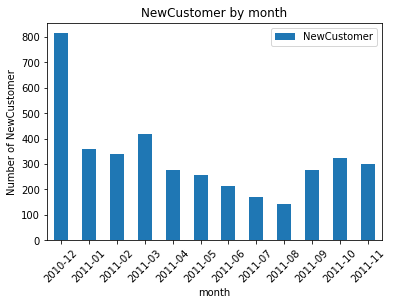

In [90]:
plt.figure(figsize=(12, 6))
df_uk_newcus_bymonth.plot.bar()

plt.title("NewCustomer by month")
plt.xlabel('month')
plt.ylabel('Number of NewCustomer')
plt.xticks(rotation=45)
plt.show()

**Observations:**
* Should neglect 2010-12
* high number of new customers in Mar
* low number of new customers in Aug

---
# 4) RFM Analysis<a class="anchor" id="RFM"></a>

**RFM** (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. 
RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

1. Recency (**R**): How recently did the customer purchase? (Days since last purchase)
2. Frequency (**F**): How often do they purchase? (Total number of purchases)
3. Monetary (**M**): How much do they spend? (Total money this customer spent)

Before starting RFM analysis we need to set objective and outcome of analysis, for this example goal is to define class of customer example - Platinum, Gold and Silver.
1. Gold customer - frequent and more revenue generator.
2. Silver customer - frequent but less revenue generator.
3. Bronze customer - less frequent and less revenue generator.

## 4.1) Recency<a class="anchor" id="4.1"></a>
Days since last purchase

In [42]:
# Using df focusing in uk as mentioned in Conclusion in part2 EDA
df_uk_rfm = df_uk.copy()

# We only need date indtead of date & time here
df_uk_rfm['InvoiceDate'] = df_uk_rfm['InvoiceDate'].dt.date

df_uk_rfm

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,20.34
...,...,...,...,...,...,...,...,...
516364,579885,85034C,3 ROSE MORRIS BOXED CANDLES,4,2011-11-30,1.25,15444,5.00
516365,579885,21742,LARGE ROUND WICKER PLATTER,2,2011-11-30,5.95,15444,11.90
516366,579885,23084,RABBIT NIGHT LIGHT,6,2011-11-30,2.08,15444,12.48
516367,579885,21257,VICTORIAN SEWING BOX MEDIUM,1,2011-11-30,7.95,15444,7.95


In [43]:
# date
earliest_date = df_uk_rfm.InvoiceDate.min()
latest_date = df_uk_rfm.InvoiceDate.max()
time_period = latest_date - earliest_date

print('earliest_date:', earliest_date)
print('latest_date:', latest_date)
print('time_period:', time_period)

earliest_date: 2010-12-01
latest_date: 2011-11-30
time_period: 364 days, 0:00:00


**Observations:**
* max Recency = 364 (purchased 1 year ago)
* min Recency = 0 (just purchased on the latest_date: 2011-11-30)

In [44]:
# Groupby CustomerID and find the max of InvoiceDate (lastest purchase date)
df_recency = df_uk_rfm.groupby(['CustomerID']).agg({'InvoiceDate': np.max})

# Recency
df_recency['Recency'] = latest_date - df_recency.InvoiceDate

# Convert timedelta to int
df_recency['Recency'] = df_recency['Recency'].dt.days

df_recency

,InvoiceDate,Recency
CustomerID,,
12346,2011-01-18,316
12747,2011-11-17,13
12748,2011-11-29,1
12749,2011-11-17,13
12820,2011-10-26,35
...,...,...
18280,2011-03-07,268
18281,2011-06-12,171
18282,2011-08-05,117


## 4.2) Frequency<a class="anchor" id="4.2"></a>
Total number of purchases in the last year

In [45]:
# Using df focusing in uk as mentioned in Conclusion in part2 EDA
df_uk_rfm = df_uk.copy()

df_uk_rfm

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,20.34
...,...,...,...,...,...,...,...,...
516364,579885,85034C,3 ROSE MORRIS BOXED CANDLES,4,2011-11-30 17:37:00,1.25,15444,5.00
516365,579885,21742,LARGE ROUND WICKER PLATTER,2,2011-11-30 17:37:00,5.95,15444,11.90
516366,579885,23084,RABBIT NIGHT LIGHT,6,2011-11-30 17:37:00,2.08,15444,12.48
516367,579885,21257,VICTORIAN SEWING BOX MEDIUM,1,2011-11-30 17:37:00,7.95,15444,7.95


In [46]:
# drop_duplicates ['CustomerID','InvoiceNo']
df_uk_rfm = df_uk_rfm.drop_duplicates(subset=['CustomerID','InvoiceNo'], keep="first") 

df_uk_rfm

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,15.30
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,54.08
21,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047,25.50
25,536369,21756,BATH BUILDING BLOCK WORD,3,2010-12-01 08:35:00,5.95,13047,17.85
...,...,...,...,...,...,...,...,...
516074,579865,23016,GLASS TWIST BON BON JAR,1,2011-11-30 16:39:00,7.85,16915,7.85
516083,579867,35970,ZINC FOLKART SLEIGH BELLS,12,2011-11-30 16:41:00,1.69,16265,20.28
516116,579868,23354,6 GIFT TAGS 50'S CHRISTMAS,24,2011-11-30 16:43:00,0.83,15544,19.92
516153,579872,23508,MINI PLAYING CARDS DOLLY GIRL,14,2011-11-30 16:54:00,0.42,14085,5.88


In [47]:
# Group by CustomerID
df_frequency = df_uk_rfm.groupby('CustomerID').agg({'InvoiceNo': 'count'})

df_frequency.columns = ['Frequency']

df_frequency

,Frequency
CustomerID,
12346,1
12747,10
12748,201
12749,4
12820,3
...,...
18280,1
18281,1
18282,1


## 4.3) Monetary<a class="anchor" id="4.3"></a>
Total money this customer spent

In [48]:
# Using df focusing in uk as mentioned in Conclusion in part2 EDA
df_uk_rfm = df_uk.copy()

df_uk_rfm

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,20.34
...,...,...,...,...,...,...,...,...
516364,579885,85034C,3 ROSE MORRIS BOXED CANDLES,4,2011-11-30 17:37:00,1.25,15444,5.00
516365,579885,21742,LARGE ROUND WICKER PLATTER,2,2011-11-30 17:37:00,5.95,15444,11.90
516366,579885,23084,RABBIT NIGHT LIGHT,6,2011-11-30 17:37:00,2.08,15444,12.48
516367,579885,21257,VICTORIAN SEWING BOX MEDIUM,1,2011-11-30 17:37:00,7.95,15444,7.95


In [49]:
df_monetary = df_uk_rfm.groupby(['CustomerID']).agg({'TotalPrice': np.sum})
df_monetary.columns = ['Monetary']

df_monetary

,Monetary
CustomerID,
12346,77183.60
12747,3757.51
12748,32649.46
12749,3327.82
12820,731.99
...,...
18280,180.60
18281,80.82
18282,100.21


## 4.4) Combine into RFM table<a class="anchor" id="4.4"></a>

In [50]:
df_rfm = pd.concat([df_recency, df_frequency, df_monetary], axis=1).drop('InvoiceDate', axis=1)
df_rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346,316,1,77183.60
12747,13,10,3757.51
12748,1,201,32649.46
12749,13,4,3327.82
12820,35,3,731.99
...,...,...,...
18280,268,1,180.60
18281,171,1,80.82
18282,117,1,100.21


---
## 4.5) Customer segments with RFM Model<a class="anchor" id="4.5"></a>

### 4.5.1) KMeans<a class="anchor" id="4.5.1"></a>

### 1) Find optimal number of cluster

Text(0, 0.5, 'inertia')

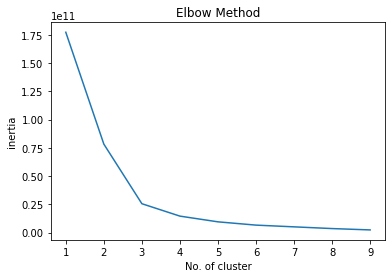

In [51]:
from sklearn.cluster import KMeans

inertia = []     # sum of dist. of sample to their closest cluster center
for i in range(1,10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=1999)
    kmeans.fit(df_rfm)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(1,10), inertia)
plt.title('Elbow Method')
plt.xlabel('No. of cluster')
plt.ylabel('inertia' )

**Observations:**
* Optimal number of cluster = 3

### 2) KMeans Clustering Model with 3 clusters

In [52]:
kmeans_3 = KMeans(n_clusters=3, random_state=1999)
kmeans_3.fit(df_rfm)

df_rfm['Cluster'] = kmeans_3.labels_
df_rfm

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,316,1,77183.60,1
12747,13,10,3757.51,0
12748,1,201,32649.46,1
12749,13,4,3327.82,0
12820,35,3,731.99,0
...,...,...,...,...
18280,268,1,180.60,0
18281,171,1,80.82,0
18282,117,1,100.21,0


### 3) Cluster Analysis

In [53]:
df_rfm[df_rfm.Cluster==0].describe()

,Recency,Frequency,Monetary,Cluster
count,3855.000000,3855.000000,3855.000000,3855.0
mean,90.724254,3.783398,1311.255819,0.0
std,98.189204,4.861180,1999.733942,0.0
min,0.000000,1.000000,0.000000,0.0
25%,16.000000,1.000000,291.645000,0.0
50%,49.000000,2.000000,623.750000,0.0
75%,146.000000,4.000000,1487.250000,0.0
max,364.000000,91.000000,19967.450000,0.0


**Observations: Cluster=0**

**Bronze customer (number=3855)**
* Highest Recency: Inactive customers
* Lowest Frequency: Inactive customers
* Lowest Monetary: Low-spending customers
* **Worthless Customers**

In [54]:
df_rfm[df_rfm.Cluster==1].describe()

,Recency,Frequency,Monetary,Cluster
count,30.000000,30.000000,30.000000,30.0
mean,31.200000,41.866667,44665.201667,1.0
std,73.195723,40.851905,17247.752050,0.0
min,0.000000,1.000000,23460.410000,1.0
25%,2.000000,16.750000,29727.947500,1.0
50%,7.500000,29.500000,40986.230000,1.0
75%,16.000000,50.000000,55262.872500,1.0
max,316.000000,201.000000,83683.060000,1.0


**Observations: Cluster=1**

**Silver customer (number=30)**
* Medium Recency: Occasionally customers
* High Frequency: Frequent customers
* Low Monetary: Low-spending customers, they bought inexpensive items
* high std: This cluster has a large variance
* **Occasionally Low-spending Customers**

In [55]:
df_rfm[df_rfm.Cluster==2].describe()

,Recency,Frequency,Monetary,Cluster
count,2.000000,2.000000,2.000000,2.0
mean,1.500000,51.000000,220580.075000,2.0
std,0.707107,8.485281,39020.535136,0.0
min,1.000000,45.000000,192988.390000,2.0
25%,1.250000,48.000000,206784.232500,2.0
50%,1.500000,51.000000,220580.075000,2.0
75%,1.750000,54.000000,234375.917500,2.0
max,2.000000,57.000000,248171.760000,2.0


**Observations: Cluster=2**

**Gold customer (number=2)**
* Lowest Recency: Highly active customers
* Highest Frequency: Highly frequent customers
* Highest Monetary: High-spending customers
* **High-value Customers**

---
### 4.5.2) RFM Scores<a class="anchor" id="4.5.2"></a>

In [91]:
df_rfm_scores = df_rfm.copy()

df_rfm_scores

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,316,1,77183.60,1
12747,13,10,3757.51,0
12748,1,201,32649.46,1
12749,13,4,3327.82,0
12820,35,3,731.99,0
...,...,...,...,...
18280,268,1,180.60,0
18281,171,1,80.82,0
18282,117,1,100.21,0


In [92]:
df_rfm_scores_quantile = df_rfm_scores.drop('Cluster', axis=1).quantile(q=[0.25,0.5,0.75])
df_rfm_scores_quantile

,Recency,Frequency,Monetary
0.25,15.0,1.0,294.260
0.50,48.0,2.0,632.070
0.75,145.0,4.0,1521.815


In [93]:
def RScore(x, rfm, df):
    """
    Lower the recency, good for store (1: best, 4: worst)
    Arguments:
    x = value
    rfm = recency, monetary_value, frequency
    df = quartiles df
    """
    if x <= df.loc[0.25, rfm]:
        return 1
    elif x <= df.loc[0.50, rfm]:
        return 2
    elif x <= df.loc[0.75, rfm]: 
        return 3
    else:
        return 4

def FMScore(x, rfm, df):
    """
    Higher value of frequency and monetary lead to a good consumer (1: best, 4: worst)
    Arguments:
    x = value
    rfm = recency, monetary_value, frequency
    df = quartiles df
    """
    if x <= df.loc[0.25, rfm]:
        return 4
    elif x <= df.loc[0.50, rfm]:
        return 3
    elif x <= df.loc[0.75, rfm]: 
        return 2
    else:
        return 1

In [94]:
df_rfm_scores['Rscore'] = df_rfm_scores['Recency'].apply(RScore,args=('Recency', df_rfm_scores_quantile))
df_rfm_scores['Fscore'] = df_rfm_scores['Frequency'].apply(FMScore, args=('Frequency', df_rfm_scores_quantile))
df_rfm_scores['Mscore'] = df_rfm_scores['Monetary'].apply(FMScore, args=('Monetary', df_rfm_scores_quantile))

df_rfm_scores['Totalscore'] = df_rfm_scores.Rscore + df_rfm_scores.Fscore + df_rfm_scores.Mscore

df_rfm_scores['RFMscore'] = df_rfm_scores.Rscore.astype(str) + df_rfm_scores.Fscore.astype(str) + df_rfm_scores.Mscore.astype(str)

df_rfm_scores.head()

,Recency,Frequency,Monetary,Cluster,Rscore,Fscore,Mscore,Totalscore,RFMscore
CustomerID,,,,,,,,,
12346,316,1,77183.60,1,4,4,1,9,441
12747,13,10,3757.51,0,1,1,1,3,111
12748,1,201,32649.46,1,1,1,1,3,111
12749,13,4,3327.82,0,1,2,1,4,121
12820,35,3,731.99,0,2,2,2,6,222


### RFM Scores Segmentation Analysis

In [119]:
print("Best Customers: ",len(df_rfm_scores[df_rfm_scores['RFMscore']=='111']))
print('Loyal Customers: ',len(df_rfm_scores[df_rfm_scores['Fscore']==1]))
print("Big Spenders: ",len(df_rfm_scores[df_rfm_scores['Mscore']==1]))
print('Almost Lost: ', len(df_rfm_scores[df_rfm_scores['RFMscore']=='311']))
print('Lost Customers: ',len(df_rfm_scores[df_rfm_scores['RFMscore']=='411']))
print('Lost Cheap Customers: ',len(df_rfm_scores[df_rfm_scores['RFMscore']=='444']))

Best Customers:  396
Loyal Customers:  955
Big Spenders:  972
Almost Lost:  100
Lost Customers:  14
Lost Cheap Customers:  396


![](https://i.imgur.com/YmItbbm.png?)

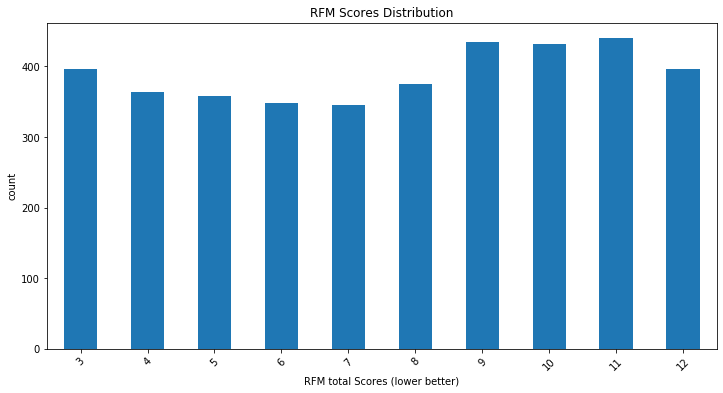

In [121]:
plt.figure(figsize=(12, 6))
df_rfm_scores.Totalscore.value_counts().sort_index().plot.bar()

plt.xlabel('RFM total Scores (lower better)')
plt.ylabel('count')
plt.title("RFM Scores Distribution")
plt.xticks(rotation=45)
plt.show()

**Observations:**
* Similar distribution because of using quantile(q=[0.25,0.5,0.75])

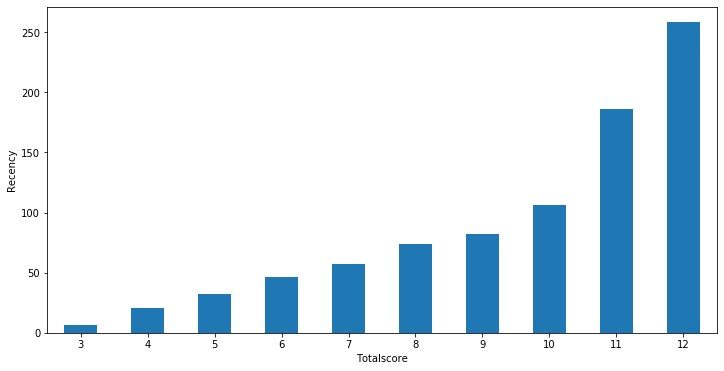

In [115]:
plt.figure(figsize=(12, 6))
df_rfm_scores.groupby('Totalscore')['Recency'].mean().plot.bar()

plt.xlabel('Totalscore')
plt.ylabel('Recency')
plt.xticks(rotation=0)
plt.show()

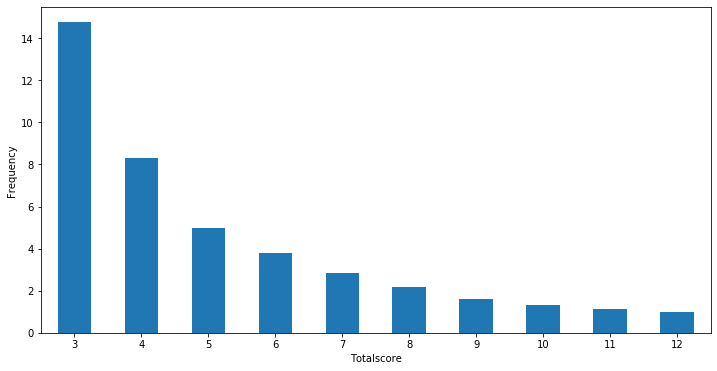

In [116]:
plt.figure(figsize=(12, 6))
df_rfm_scores.groupby('Totalscore')['Frequency'].mean().plot.bar()

plt.xlabel('Totalscore')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

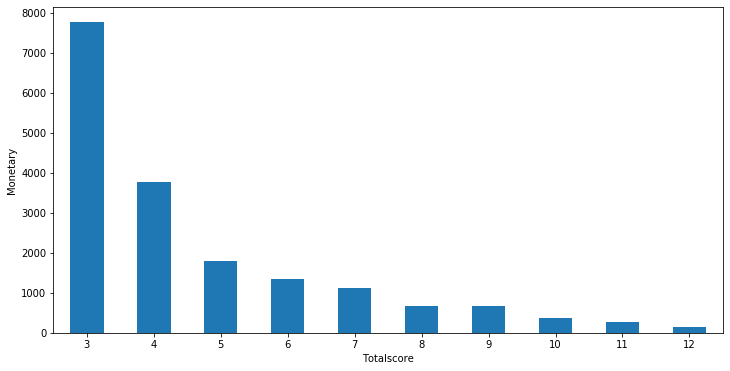

In [117]:
plt.figure(figsize=(12, 6))
df_rfm_scores.groupby('Totalscore')['Monetary'].mean().plot.bar()

plt.xlabel('Totalscore')
plt.ylabel('Monetary')
plt.xticks(rotation=0)
plt.show()